In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.expand_frame_repr', False) 
tickers = ['MASI', 'MSI20', 'ESG10']

In [28]:
def extract_data(file_path):
    return pd.read_excel(file_path)

folder = 'indices/'
ext = '.xls'

In [29]:
close_df = pd.DataFrame()



for ticker in tickers:
    file = folder + ticker + ext
    data = extract_data(file)
    data = data.set_index('Date')

    close_df[ticker] = data['Dernier']

log_returns = np.log(close_df / close_df.shift(1))
log_returns = log_returns.dropna()

In [30]:
portfolio_value = 1_000_000
print(log_returns)

                MASI     MSI20     ESG10
Date                                    
2023-12-28 -0.003834 -0.003905 -0.007972
2023-12-27  0.004750  0.006431  0.005233
2023-12-26 -0.001542 -0.002264 -0.002314
2023-12-25  0.005107  0.005775  0.005795
2023-12-22  0.002870  0.002999  0.001513
...              ...       ...       ...
2023-01-06 -0.009048 -0.008924 -0.009350
2023-01-05  0.032689  0.034588  0.037042
2023-01-04  0.038938  0.037921  0.042805
2023-01-03  0.018222  0.019822  0.015368
2023-01-02  0.007269  0.007584  0.001556

[248 rows x 3 columns]


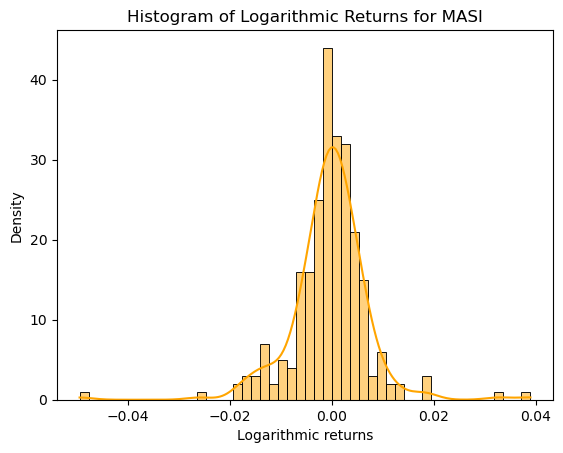

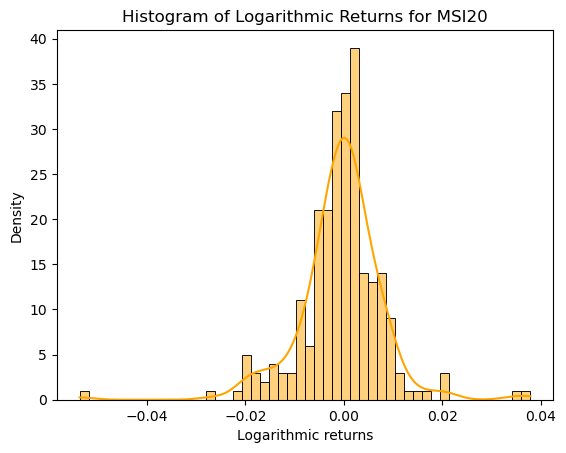

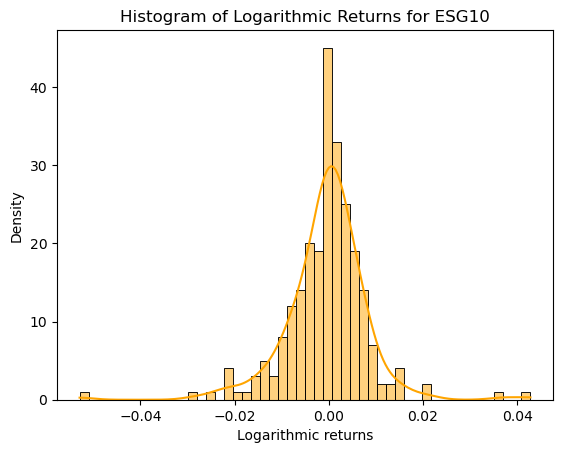

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que log_returns[ticker] contient vos données de rendements logarithmiques
for ticker in tickers:
    # Créer l'histogramme avec seaborn
    sns.histplot(log_returns[ticker], bins=50, kde=True, color='orange')

    # Ajouter des étiquettes et un titre
    plt.xlabel('Logarithmic returns')
    plt.ylabel('Density')
    plt.title(f'Histogram of Logarithmic Returns for {ticker}')

    # Afficher le graphique
    plt.show()


## Statistics of our samples

In [5]:
from scipy.stats import skew, kurtosis, jarque_bera

statistics = pd.DataFrame(
    index=[
        'Size',
        'Mean',
        'Standard deviation',
        'Skewness',
        'Excess Kurtosis',
        'Jarque-Bera'
    ]
)

for ticker in tickers:
    statistics[ticker] = [
            len(log_returns[ticker]),
            np.mean(log_returns[ticker]),
            np.std(log_returns[ticker]),
            skew(log_returns[ticker]),
            kurtosis(log_returns[ticker], fisher=False),
            jarque_bera(log_returns[ticker])[0]
        ]

print(statistics)

                           MASI       MSI20       ESG10
Size                 248.000000  248.000000  248.000000
Mean                  -0.000490   -0.000582   -0.000454
Standard deviation     0.007713    0.008586    0.008785
Skewness              -0.466091   -0.602006   -0.445500
Excess Kurtosis       12.811867   10.840732   11.066625
Jarque-Bera         1003.797509  650.242761  680.597953


## VaRs Calculs

In [17]:
from scipy.optimize import curve_fit

# Fonction de modèle (fonction linéaire)
def linear_model(x, b0, b1):
    return b0 + b1 * x

def gamma(k,x):
    N = len(x)
    som = 0
    for j in range(1,k):
        som += np.log(x[N-j])-np.log(x[N-k-1])
    results = som / k
    return results

rt = log_returns[ticker].apply(abs).sort_values()

# Données pour ajustement (remplacez-les par vos propres données)
N = len(rt)
k_values = np.linspace(1,N//2,N//2).astype(int)  # Remplacez ... par les valeurs réelles de k
gamma_values = [gamma(k,rt) for k in k_values]  # Remplacez ... par les valeurs réelles de gamma

# Ajustement du modèle
params, covariance = curve_fit(linear_model, k_values, gamma_values)

# Récupération des paramètres ajustés
b0_optimal, b1_optimal = params

deg_freedom = 1/b0_optimal 
#deg_freedom = (1/b0_optimal).astype(int) + 1

In [26]:
from scipy.stats import norm,t

    

confidence_levels = [0.950, 0.975, 0.980, 0.985, 0.990, 0.995, 0.999]
var_ntx = ['var-n','var-t','var-x']
col = ['r','b','y']

tableau_var = pd.DataFrame(index=confidence_levels)

for ticker in tickers:
    std = statistics.loc['Standard deviation', ticker]
    mu = statistics.loc['Mean', ticker]
    rt = log_returns[ticker]
    
    # calcul var_n
    var_n = [ - std * norm.ppf(1-cl) for cl in confidence_levels]
    
    # calcul var_t
    k = np.mean(((rt - mu) / std) ** 2)
    beta = std ** 2 * (k + 3) / (2 * k + 3)
    n = 6 / k + 4
    var_t = [- np.sqrt(beta) * t.ppf(1-cl, n) for cl in confidence_levels]
    
    # calcul var_x
    calcul = std / (np.sqrt(deg_freedom / (deg_freedom-2)))
    var_x = [- t.ppf(1-cl, deg_freedom)*calcul for cl in confidence_levels]
    
    # pushing in tab var
    tableau_var[ticker+' var-n'] = var_n
    tableau_var[ticker+' var-t'] = var_t
    tableau_var[ticker+' var-x'] = var_x    

----------------------------Value At Risks----------------------------

                0.950     0.975     0.980     0.985     0.990     0.995     0.999
MASI var-n   0.012687  0.015117  0.015840  0.016738  0.017943  0.019867  0.023835
MASI var-t   0.012504  0.015371  0.016276  0.017436  0.019066  0.021864  0.028586
MASI var-x   0.010480  0.014172  0.015505  0.017349  0.020220  0.026010  0.045486
MSI20 var-n  0.014123  0.016828  0.017634  0.018632  0.019974  0.022116  0.026533
MSI20 var-t  0.013919  0.017111  0.018118  0.019410  0.021225  0.024339  0.031822
MSI20 var-x  0.011666  0.015776  0.017260  0.019313  0.022509  0.028954  0.050635
ESG10 var-n  0.014451  0.017219  0.018043  0.019065  0.020438  0.022630  0.027149
ESG10 var-t  0.014242  0.017509  0.018539  0.019861  0.021718  0.024904  0.032561
ESG10 var-x  0.011937  0.016142  0.017661  0.019762  0.023032  0.029627  0.051811


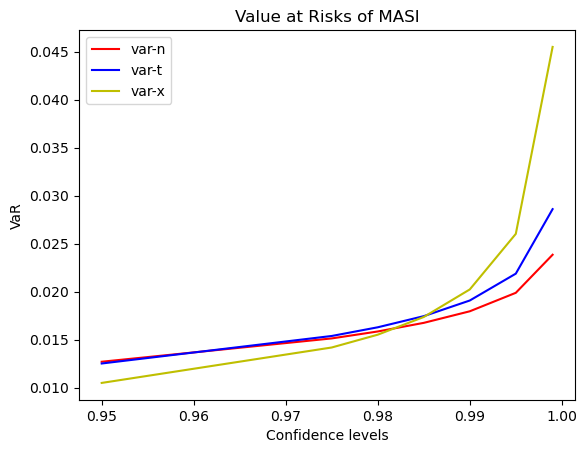

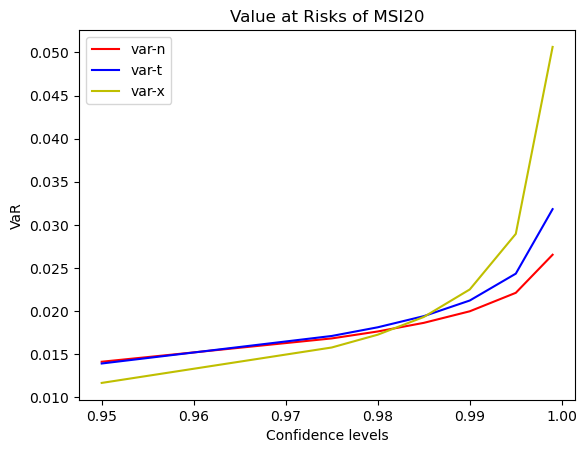

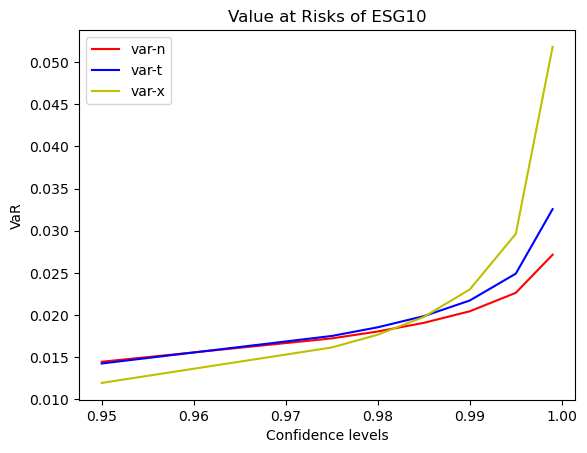

In [70]:
print('----------------------------Value At Risks----------------------------\n')
print(tableau_var.T)

for ticker in tickers :
    for v,c in zip(var_ntx,col) :
        plt.plot(tableau_var[ticker+' '+v],color=c,label=v)
    plt.xlabel('Confidence levels')
    plt.ylabel('VaR')
    plt.title(f'Value at Risks of {ticker}')
    plt.legend()
    plt.show()

In [71]:
tab = pd.DataFrame(index=confidence_levels)

for ticker in tickers :
    for v in var_ntx :
        l = []
        for cl in confidence_levels :
            var = tableau_var[ticker+' '+v][cl]
            tab_ec = [x for x in log_returns[ticker] if x < 0 and x < -var]
            l.append(len(tab_ec) / len(log_returns[ticker]))
        tab[ticker+' '+v] = l

print('----------------------------Failure Rates----------------------------\n')
print(tab.T)

----------------------------Failure Rates----------------------------

                0.950     0.975     0.980     0.985     0.990     0.995     0.999
MASI var-n   0.060484  0.036290  0.028226  0.028226  0.008065  0.008065  0.008065
MASI var-t   0.064516  0.032258  0.028226  0.016129  0.008065  0.008065  0.004032
MASI var-x   0.076613  0.040323  0.032258  0.020161  0.008065  0.004032  0.004032
MSI20 var-n  0.064516  0.044355  0.036290  0.032258  0.016129  0.008065  0.008065
MSI20 var-t  0.064516  0.040323  0.032258  0.024194  0.008065  0.008065  0.004032
MSI20 var-x  0.080645  0.044355  0.040323  0.028226  0.008065  0.004032  0.004032
ESG10 var-n  0.048387  0.032258  0.032258  0.032258  0.024194  0.012097  0.008065
ESG10 var-t  0.056452  0.032258  0.032258  0.028226  0.024194  0.012097  0.004032
ESG10 var-x  0.072581  0.040323  0.032258  0.028226  0.012097  0.004032  0.004032


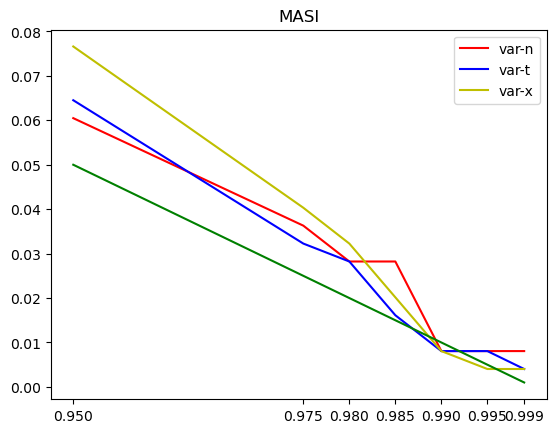

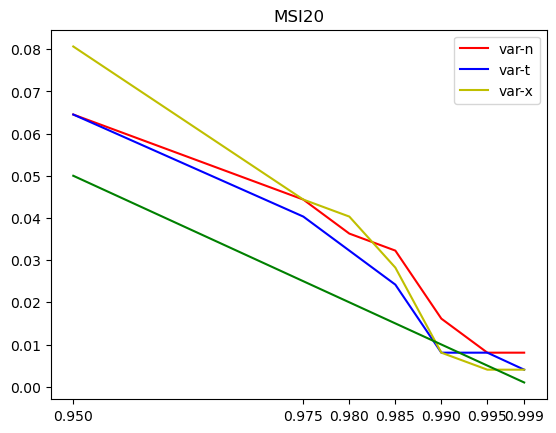

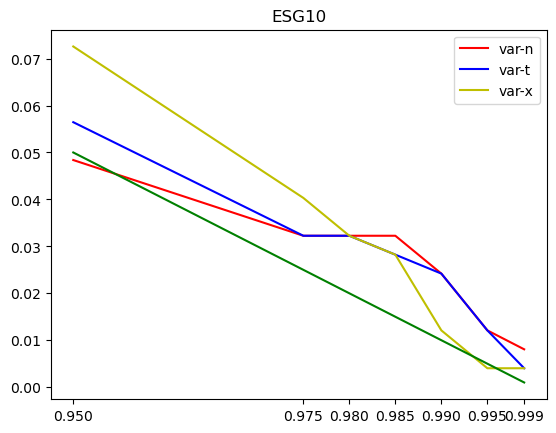

In [24]:
for ticker in tickers :
    for v,c in zip(var_ntx,col) :
        plt.plot(tab[ticker+' '+v],color=c,label=v)

#plt.plot(tab['MASI var-t'],color='b')

    # Repere norme
    y = np.ones(len(confidence_levels))
    y = y - confidence_levels
    plt.plot(confidence_levels,y,color='g')

    plt.xticks(confidence_levels)
    plt.title(ticker)
    plt.legend()
    plt.show()